## Modules à importer

In [3]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa import tools
from variaIa.tools import surveys, df_cons, df_nc, df_c, df_full
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Comparison plot

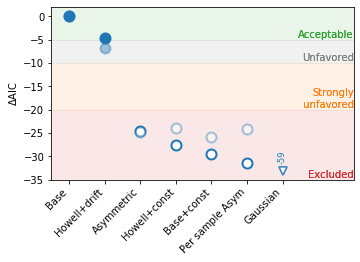

In [3]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py = pd.read_csv('../../Data/df_comparaison.dat')
d_mod_comp_cons = pd.read_csv('../../Data/df_comparaison_cons-supercut.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../Images/pdf/mod_comp-supercut.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mod_comp-supercut.png', bbox_inches='tight', dpi=600)

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [14]:
def set_survey(cons, su):
    global df
    if su == 'All':
        df = df_cons(cons)
    elif 'n' in su:
        df = df_cons(cons)[df_cons(cons)['survey'] != su.split('n')[-1]]
    else:
        df = df_cons(cons)[df_cons(cons)['survey'] == su]
    return df

int_set_su = ipw.interactive(set_survey, cons=tools.cons, su=tools.su)
display(int_set_su)

smap = plt.cm.get_cmap('cividis')
colors = {'SNF': plt.cm.binary(0.9),
          'SDSS': smap(0.1),
          'PS1': smap(0.5),
          'SNLS': smap(0.8),
          'HST': smap(0.99),  # for cividis
          #'HST': smap(300)}  # for viridis
          'All': (255/255, 51/255, 0/255)} 

alphacolors = {'1': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .1)
                     for survey in surveys},
               '3': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .3)
                     for survey in surveys},
               '5': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .5)
                     for survey in surveys},
               '8': {survey:
                     (colors[survey][0], colors[survey][1], colors[survey][2], .8)
                     for survey in surveys}} 

df_nHST = df_nc[df_nc['survey'] != 'HST']

interactive(children=(Checkbox(value=False, description='Conservative'), Dropdown(description='Survey:', index…

# Individual model plots

(-3.2, 3.2)

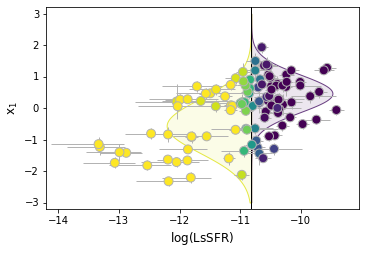

In [9]:
gen.set_model('Evol2G2M2S')
gen.set_data(df)
how = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

how.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_howell.pdf', bbox_inches='tight')

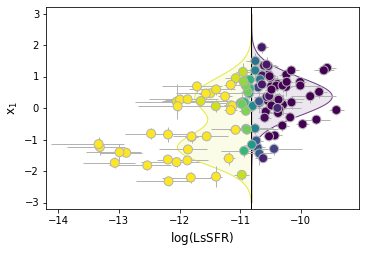

In [17]:
gen.set_model('Evol3G2M2S')
gen.set_data(df)
base = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

base.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
            facealpha=1, show_leg=False)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

fig.savefig('../../../../Images/model_base.pdf', bbox_inches='tight')

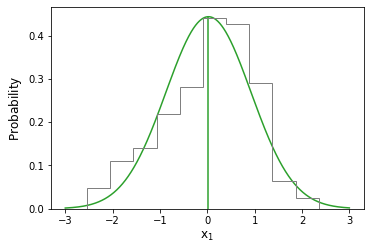

In [16]:
gen.set_model('Evol1G1M1S')
gen.set_data(df)
gauss = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

gauss.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_gauss.pdf', bbox_inches='tight')

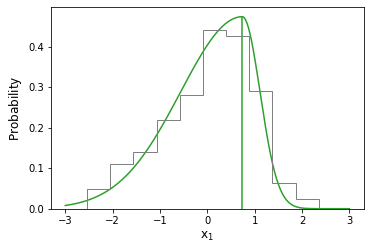

In [20]:
gen.set_model('Evol1G1M2S')
gen.set_data(df)
asymm = gen.fit()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

asymm.show_model_tot(ax=ax)
fig.savefig('../../../../Images/model_asymm.pdf', bbox_inches='tight')

## With _z-only_

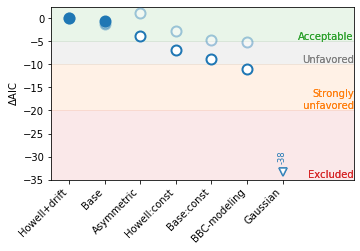

In [8]:
fig = plt.figure(figsize=[6,4])
ax = fig.add_axes([0.15,0.3,0.7,0.6])
xmax = 8

d_mod_comp_py = pd.read_csv('../../Data/df_comparaison_zonly.dat')
d_mod_comp_cons = pd.read_csv('../../Data/df_comparaison_zonly_cons.dat')

def show_results(data_, show_text=True, show_aicc=True, **kwargs):
    """ """
    if show_aicc:
        ykey = '$\Delta$ AIC'
        ylow = -35
        yscale = 'linear'
        shift = 0.95
    else:
        ykey = 'Proba'
        ylow = 1e-6
        yscale = 'log'
        shift = 1.5
    
    flag_fixed = np.asarray(data_["Fixed"], dtype="bool")
    flag_below = np.asarray(data_[ykey]<ylow, dtype="bool")
    prop = {**dict(marker="o", ms=10, ls="None", mew=2, zorder=8),**kwargs}
    prop_notfixed = dict(mfc="C0", mec="C0")
    prop_fixed = dict(mfc="w", mec="C0")
    # above Cut
    flag = ~flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag], **{**prop, **prop_notfixed})
    flag = flag_fixed*~flag_below
    ax.plot(data_.index[flag], data_[ykey][flag],  **{**prop, **prop_fixed})
    # Below Cut
    propbelow = {**prop, **{"marker":"v", "mew":1.5, "ms":8}}
    flag = ~flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_notfixed})
    flag = flag_fixed*flag_below
    ax.plot(data_.index[flag], [ylow*shift]*len(data_.index[flag]), **{**propbelow, **prop_fixed})
    flag = flag_below
    if show_text:
        for i in data_.index[flag]:
            ax.text(i, ylow*shift**2, "%.0f"%data_.iloc[i][ykey] if show_aicc else "%.1e"%data_.iloc[i][ykey], 
                    rotation=90, color="C0", va="bottom", ha="center", fontsize="small")
    #axt.plot(data.index, data["AICc"])
    ax.set_yscale(yscale)
    
    if not show_aicc:
        for i in [1,2,3,4,5]:
            cut = stats.norm.pdf(i, loc=0, scale=1)*2
            ax.axhspan(1e-20, cut, color="C1", alpha=0.1)
            ax.text(xmax,cut,r"$%d\sigma$"%i,va="bottom", ha="right", color="C1")
    else:
        spanprop = dict(alpha=.05, lw=.5)
        textprop = dict(va="bottom", ha="right")
        # Between 1 and 2 \sigma
        ax.axhspan(5, -5, color="tab:green", **spanprop)
        ax.text(xmax, -5, r"Acceptable", color="tab:green", **textprop)
        # Between 2 and 3 \sigma
        ax.axhspan(-5, -10, color="tab:gray", **spanprop)
        ax.text(xmax, -10, r"Unfavored", color="tab:gray", **textprop)
        # Between 3 and 5 \sigma
        ax.axhspan(-10, -20, color="tab:orange", **spanprop)
        ax.text(xmax, -20, "Strongly\n unfavored", color="tab:orange", **textprop)
        # Between 5 and lots of \sigma
        ax.axhspan(-20, ylow, color="tab:red", **spanprop)
        ax.text(xmax, ylow, r"Excluded", color="tab:red", **textprop)
        
        if not show_aicc:
            ax.set_ylabel(r"Model Probability ($e^{0.5\Delta\mathrm{AIC}}$)")
        else:
            ax.set_ylabel(r'$\Delta\mathrm{AIC}$')
    
    return(ylow)

ylow = show_results(d_mod_comp_py)
ylow = show_results(d_mod_comp_cons, alpha=.4, show_text=False)

ax.set_xticks(d_mod_comp_py.index)
ax.set_xticklabels([d_mod_comp_py.iloc[i]["Name"] for i in d_mod_comp_py.index], rotation=45, 
                   fontdict=dict(ha="right"))

ax.set_ylim(ylow, 2.5)
ax.set_xlim(-0.5, xmax)

fig.savefig('../../Images/mod_comp_zonly.pdf', bbox_inches='tight')
fig.savefig('../../Images/png/mod_comp_zonly.png', bbox_inches='tight', dpi=600)